In [1]:
import datetime

import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
import numpy as np
import pandas as pd
#import seaborn as sns
#from lightfm import LightFM
#from lightfm.evaluation import auc_score
from scipy.sparse import coo_matrix
from sklearn import preprocessing

#sns.set()

In [2]:
data = pd.read_csv('events/events.csv')
print(data.shape)
print(data.columns.tolist())
data.head()

(2756101, 5)
['timestamp', 'visitorid', 'event', 'itemid', 'transactionid']


,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [3]:
data.tail()

,timestamp,visitorid,event,itemid,transactionid
2756096,1438398785939,591435,view,261427,NaN
2756097,1438399813142,762376,view,115946,NaN
2756098,1438397820527,1251746,view,78144,NaN
2756099,1438398530703,1184451,view,283392,NaN
2756100,1438400163914,199536,view,152913,NaN


In [4]:
data.fillna(0, inplace = True)
data.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,0.0
1,1433224214164,992329,view,248676,0.0
2,1433221999827,111016,view,318965,0.0
3,1433221955914,483717,view,253185,0.0
4,1433221337106,951259,view,367447,0.0


In [5]:
events_c = data.event.value_counts()
events_c.head()
items_c = data.itemid.value_counts()
items_c.head()

187946    3412
461686    2978
5411      2334
370653    1854
219512    1800
Name: itemid, dtype: int64

(3,)
(3,)


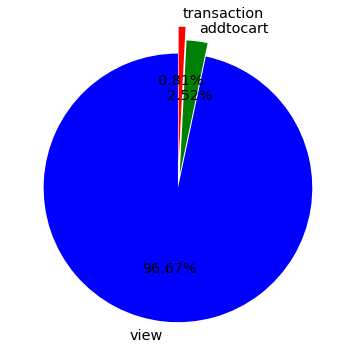

In [6]:
labels = events_c.index
print(labels.shape)
sizes = events_c.values
print(sizes.shape)
explode = (0, 0.1, 0.2)
fig, ax = plt.subplots(figsize=(6,6))
colors = ['b', 'g', 'r']

patches, texts, autotexts = ax.pie(sizes, labels=labels, explode=explode, autopct='%1.2f%%', shadow=False, startangle=90, colors=colors)

properties = fm.FontProperties()
properties.set_size('x-large')
# font size include: xx-small, x-small, small, medium, large, x-large, xx-large, larger, smaller, None

plt.setp(autotexts, fontproperties=properties)
plt.setp(texts, fontproperties=properties)

ax.axis('equal')
plt.show()

In [7]:
items = data.itemid.value_counts()
items.head()

187946    3412
461686    2978
5411      2334
370653    1854
219512    1800
Name: itemid, dtype: int64

In [8]:

for i in [2, 10, 50, 100, 1000]:
    print(f'Items that appear less than {i:>4} times:\
          {round((items < i).mean() * 100, 2)}%')

items.head(10)

Items that appear less than    2 times:          31.31%
Items that appear less than   10 times:          76.55%
Items that appear less than   50 times:          95.25%
Items that appear less than  100 times:          98.2%
Items that appear less than 1000 times:          99.98%


187946    3412
461686    2978
5411      2334
370653    1854
219512    1800
257040    1647
298009    1642
96924     1633
309778    1628
384302    1608
Name: itemid, dtype: int64

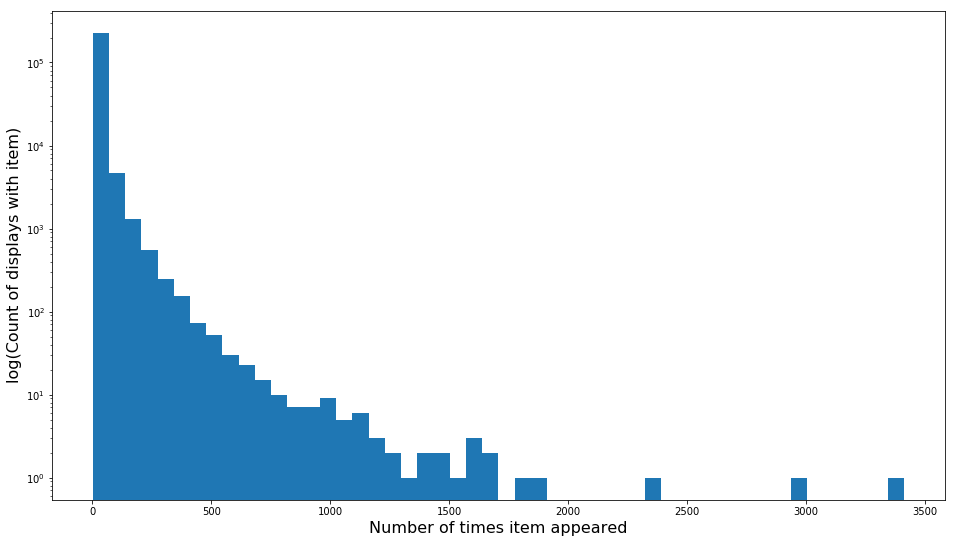

In [9]:
plt.figure(figsize=(16, 9))
plt.hist(items.values, bins=50, log=True)
plt.xlabel('Number of times item appeared', fontsize=16)
plt.ylabel('log(Count of displays with item)', fontsize=16)
plt.show()

In [10]:
### Vistors tracking

In [11]:
visitors = data.visitorid.value_counts()
visitors.head()

1150086    7757
530559     4328
152963     3024
895999     2474
163561     2410
Name: visitorid, dtype: int64

In [12]:
for i in [2, 5, 10, 15]:
    print(f'Visitors that appear less than {i:>2} times:\
          {round((visitors < i).mean() * 100, 2):.02f}%')

visitors.head(10)

Visitors that appear less than  2 times:          71.15%
Visitors that appear less than  5 times:          94.20%
Visitors that appear less than 10 times:          98.35%
Visitors that appear less than 15 times:          99.20%


1150086    7757
530559     4328
152963     3024
895999     2474
163561     2410
371606     2345
286616     2252
684514     2246
892013     2024
861299     1991
Name: visitorid, dtype: int64

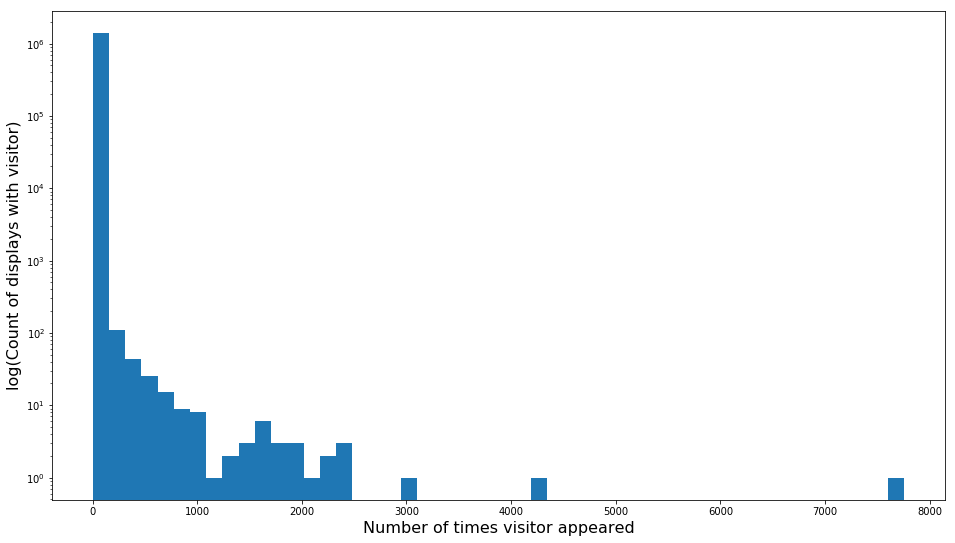

In [13]:
plt.figure(figsize=(16, 9))
plt.hist(visitors.values, bins=50, log=True)
plt.xlabel('Number of times visitor appeared', fontsize=16)
plt.ylabel('log(Count of displays with visitor)', fontsize=16)
plt.show()

In [14]:
hour = lambda x: (datetime.datetime.fromtimestamp(x)-datetime.timedelta(hours=5)).hour
timestamp = data[['timestamp', 'event']].copy()
timestamp['timestamp'] = timestamp.timestamp / 1000
timestamp['hour'] = timestamp['timestamp'].apply(hour)

timestamp.head()

,timestamp,event,hour
0,1.433221e+09,view,5
1,1.433224e+09,view,6
2,1.433222e+09,view,5
3,1.433222e+09,view,5
4,1.433221e+09,view,5


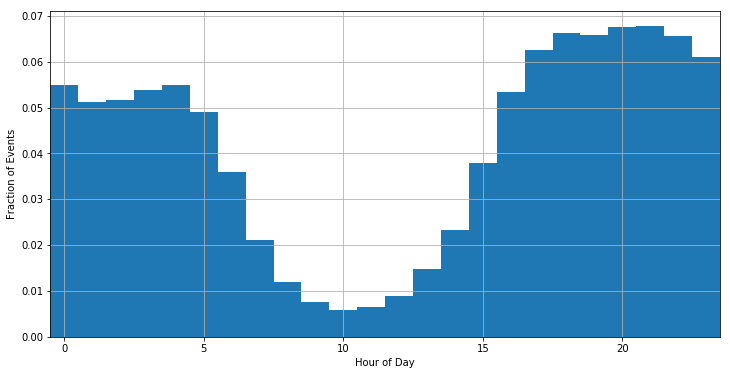

In [15]:
plt.figure(figsize=(12,6))
timestamp.hour.hist(bins=np.linspace(-0.5, 23.5, 25), alpha=1, density=True)
plt.xlim(-0.5, 23.5)
plt.xlabel("Hour of Day")
plt.ylabel("Fraction of Events")
plt.show()

In [16]:
##ITEMS...properties

In [17]:
properties = pd.concat([pd.read_csv('item_properties_part1/item_properties_part1.csv'), pd.read_csv('item_properties_part2/item_properties_part2.csv')])
print('Shape:', properties.shape)
print('Columns', properties.columns.tolist())
properties.head()

Shape: (20275902, 4)
Columns ['timestamp', 'itemid', 'property', 'value']


,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [18]:
properties.tail()

,timestamp,itemid,property,value
9275898,1433646000000,236931,929,n12.000
9275899,1440903600000,455746,6,150169 639134
9275900,1439694000000,347565,686,610834
9275901,1433646000000,287231,867,769062
9275902,1442113200000,275768,888,888666 n10800.000 746840 1318567


In [19]:
##taking only categoryID and available columns since rest data is useless for our model..

In [20]:
properties = properties.loc[properties.property.isin(['categoryid', 'available']), ]
print('Shape:', properties.shape)
properties.head()

Shape: (2291853, 4)


,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
5,1436065200000,285026,available,0
15,1437274800000,186518,available,0
79,1433646000000,423682,available,0
82,1434250800000,316253,available,1


In [21]:
categoryid = properties[properties.property=='categoryid'].drop_duplicates('itemid', keep='first')
available = properties[properties.property=='available']
categoryid.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
140,1432436400000,281245,categoryid,1277
151,1435460400000,35575,categoryid,1059
189,1437274800000,8313,categoryid,1147
197,1437879600000,55102,categoryid,47


In [22]:
categories = categoryid.value.value_counts()
categories.head(10)

342     17231
769     10982
173     10561
1301    10021
1007     9738
1142     6822
1680     6019
1250     5193
1070     4209
1483     3893
Name: value, dtype: int64

In [23]:
for i in [2, 10, 50, 100, 500, 1000, 5000]:
    print(f'Categories that appear less than {i:>4} times:\
          {round((categories < i).mean() * 100, 2)}%')

Categories that appear less than    2 times:          7.1%
Categories that appear less than   10 times:          21.8%
Categories that appear less than   50 times:          42.61%
Categories that appear less than  100 times:          56.0%
Categories that appear less than  500 times:          84.57%
Categories that appear less than 1000 times:          91.84%
Categories that appear less than 5000 times:          99.35%


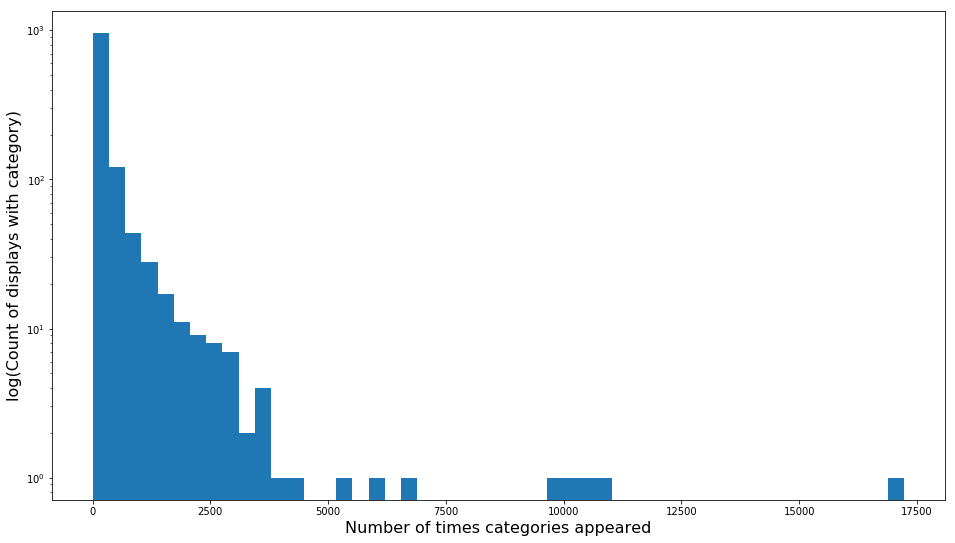

In [24]:
plt.figure(figsize=(16, 9))
plt.hist(categories.values, bins=50, log=True)
plt.xlabel('Number of times categories appeared', fontsize=16)
plt.ylabel('log(Count of displays with category)', fontsize=16)
plt.show()


In [25]:
item_category = categoryid[['itemid', 'value']]
item_category.columns = ['itemid', 'categoryid']
item_category.head()

,itemid,categoryid
0,460429,1338
140,281245,1277
151,35575,1059
189,8313,1147
197,55102,47


In [26]:
available.head()

,timestamp,itemid,property,value
5,1436065200000,285026,available,0
15,1437274800000,186518,available,0
79,1433646000000,423682,available,0
82,1434250800000,316253,available,1
96,1437274800000,430459,available,0


In [27]:
##Category tree method..(NOT KNOWN)

In [28]:
category = pd.read_csv('category_tree.csv').dropna()
print('Shape:', category.shape)
print('Columns', category.columns.tolist())
category.head()

Shape: (1644, 2)
Columns ['categoryid', 'parentid']


,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [29]:
category_parent_dict = category.set_index('categoryid').T.to_dict('list')

pd.options.mode.chained_assignment = None
item_category['parentid'] = item_category.categoryid.apply(lambda x: int(category_parent_dict.get(int(x), [x])[0]))

item_category.head()

,itemid,categoryid,parentid
0,460429,1338,1278
140,281245,1277,312
151,35575,1059,1696
189,8313,1147,1027
197,55102,47,381


In [30]:
# Format the timestamp as a date and arrange it in chronological order.
# 将时间戳格式化为日期，并且按时间顺序排列。
events = events.assign(date=pd.Series(datetime.datetime.fromtimestamp(i/1000).date() for i in events.timestamp))
events = events.sort_values('date').reset_index(drop=True)
events = events[['visitorid','itemid','event', 'date']]

NameError: name 'events' is not defined